In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import sys

from dotenv import load_dotenv

# climb up until we hit the repo root, then add src
here = Path.cwd().resolve()
while here.name != "over-intra-news" and here.parent != here:
    here = here.parent

src_path = here / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

load_dotenv()

True

# 1 Corpus exploration, cleaning, and LDA-ready news dataset

## 1.1 Background and motivation

The news parser pipeline ingests CC-NEWS WARC samples from S3 and produces a
`parsed_news_articles` warehouse table keyed by `(article_id, trading_day, session)`.
For each WARC response, the parser applies a sequence of strict gates:

- HTTP status must be `200` and `Content-Type` must contain `text/html`.
- The HTML payload is decoded into Unicode, reduced to visible ASCII text, and
  required to have at least 25 tokens and at most `MAXIMUM_ALLOWED_TOKENS`.
- Language detection via `langdetect.detect_langs` must identify English as the
  top language with probability at least `LANGUAGE_ACCEPTANCE_PROBABILITY`.
- Canonicalized article tokens must match between 1 and 3 firms in the S&P 500
  universe, using high-precision name-part matching rules.

Records that pass all gates are normalized into uppercase ASCII article bodies
and written downstream as `ArticleData` objects, together with firm CIKs, word
counts, and a scalar `language_confidence` score. These are then materialized
into the `parsed_news_articles` table via the loader utilities.

This design intentionally favors precision at the parser stage, but it still
admits several classes of noise that matter for topic modeling:

- Paywalls, “out-of-free-articles” stubs, and subscription gates that
  technically look like English HTML pages.
- Boilerplate investor-relations or syndicated press-release footers attached to
  otherwise valid articles.
- Navigation fragments, social-media widgets, and other CMS chrome that leak
  into the extracted body text.
- Non-english articles that passed the lang_detect gate (as lang_detect is stochastic).

To construct an LDA-ready corpus, the notebook adds a second layer of
post-parsing filters on top of `parsed_news_articles`:

1. **Strong English filter.**  
    only articles with `language_confidence` at least
   `STRONG_ENGLISH_CONFIDENCE_THRESHOLD = 0.999996` are retained. This tight cutoff
   is based on manual inspection of near-threshold articles: even at 0.999994
   occasional Spanish articles slipped through, so a more
   conservative threshold is justified.

2. **Boilerplate prefix filter (`NOISY_PREFIXES`).**  
   Articles whose `full_text` begins with known non-article prefixes are dropped
   entirely. These prefixes include:
   - Ticker/price tables and delayed-quote grids.
   - Subscription walls and “please log in / subscribe to continue reading”
     stubs.
   - Email-capture prompts and standalone disclaimers.
   - Captcha/error pages and “404 not found” responses that survive the HTML
     gate.

3. **Noisy substring filter (`NOISY_SUBSTRINGS`).**  
   Articles containing characteristic boilerplate substrings are removed, e.g.:
   - Inline “ADVERTISEMENT” blocks and sponsored-content labels.
   - “READ MORE / RELATED ARTICLES” link farms injected mid-article.
   - Syndication and wire-service boilerplate such as
     “THIS STORY WAS GENERATED BY AUTOMATED INSIGHTS” or
     “DISTRIBUTED BY PUBLIC, UNEDITED”.
   - Copyright blocks and “ALL RIGHTS RESERVED” footers.
   - Social-media widgets such as “SHARE THIS ARTICLE” or “FOLLOW US ON …”.

These post-parser gates are deliberately conservative: they are designed to
sacrifice recall in exchange for a high-precision core corpus that looks like
genuine firm-specific news when inspected manually. The resulting article ID set
serves as the **baseline training corpus for the first LDA iteration**.

Subsequent sections of the notebook:

- materialize this filtered article set back into a DataFrame via SQL;
- apply standard NLP pre-processing (tokenization, stop-word removal, vocabulary
  construction); and
- Ingest the processed data into a table to be ready for LDA modeling.

If diagnostics suggest unstable or noisy topics, subsequent iterations will be performed.
These will tighten noise patterns or add additional gates, but this notebook defines the
first rigorously filtered, LDA-ready news dataset derived from the CC-NEWS
pipeline.


In [ ]:
import datetime as dt
from infra.logging.infra_logger import InfraLogger, initialize_logger
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_utils import sample_corpus_per_day
start_date = dt.date(2016, 8, 1)
end_date = dt.date(2025, 8, 1)
logger: InfraLogger = initialize_logger("corpus_exploration_and_cleaning_utils_sample_corpus_per_day", "INFO")

# For logging to appear change the log level to DEBUG.
# This is a No-OP if real_run is not set to TRUE.
sample_id_set = sample_corpus_per_day(start_date, end_date, logger)

### 1.2 Temporal coverage of filtered articles and CIKs

Before constructing an LDA design matrix, the temporal coverage of the cleaned news
corpus is examined over the full sampling window from 2016-08-01 through 2025-08-01.
All diagnostics in this section are based on the **filtered article set** obtained from
`parsed_news_articles` after applying:

- the parser-level gates described in Section 1.1 (HTTP status, HTML decoding,
  length, language, and firm-match filters), and
- the post-parser strong-English and boilerplate filters
  (`STRONG_ENGLISH_CONFIDENCE_THRESHOLD`, `NOISY_PREFIXES`, `NOISY_SUBSTRINGS`).

The first set of plots reports the **number of retained articles per trading day**,
separately for the overnight and intraday sessions and then for both sessions combined.
These time series provide a visual check that:

- coverage is non-degenerate across the sample (no long stretches with zero articles),
- major shifts in CC-NEWS availability or parser behavior are detectable as level
  shifts, and
- the relative density of overnight vs. intraday news is understood before
  constructing session-specific signals.

The second set of plots summarizes **firm-level news support**. Using the CIK lists
attached to each article, the diagnostics report, for each CIK:

- the total number of articles mentioning the firm;
- the number of unique trading days with at least one article;
- the number of unique months with at least one article; and
- the number of unique years with at least one article.

These histograms quantify how evenly the cleaned corpus is distributed across firms
and over time. In particular, they highlight sparsely covered CIKs whose topic
exposures would be poorly estimated, and they inform later decisions about restricting
the tradable universe or imposing minimum-coverage thresholds prior to LDA training
and return-prediction regressions.

> **Note — resource usage**
>
> Loading the filtered article sample into `filtered_sample_df` is memory-intensive:
> on the reference machine used to develop this notebook, it occupies
> roughly **5–6 GB** of RAM.

In [3]:
import pandas as pd
from notebooks_utils.data_notebooks_utils.general_data_notebooks_utils import connect_with_sqlalchemy
article_sample_query: str = """
    SELECT *
    FROM parsed_news_articles
    WHERE article_id = ANY(%(samples)s)
"""
engine = connect_with_sqlalchemy()
filtered_sample_df: pd.DataFrame = pd.read_sql(
    article_sample_query,
    engine,
    params={"samples": list(sample_id_set)},
).drop_duplicates(subset=["full_text"])

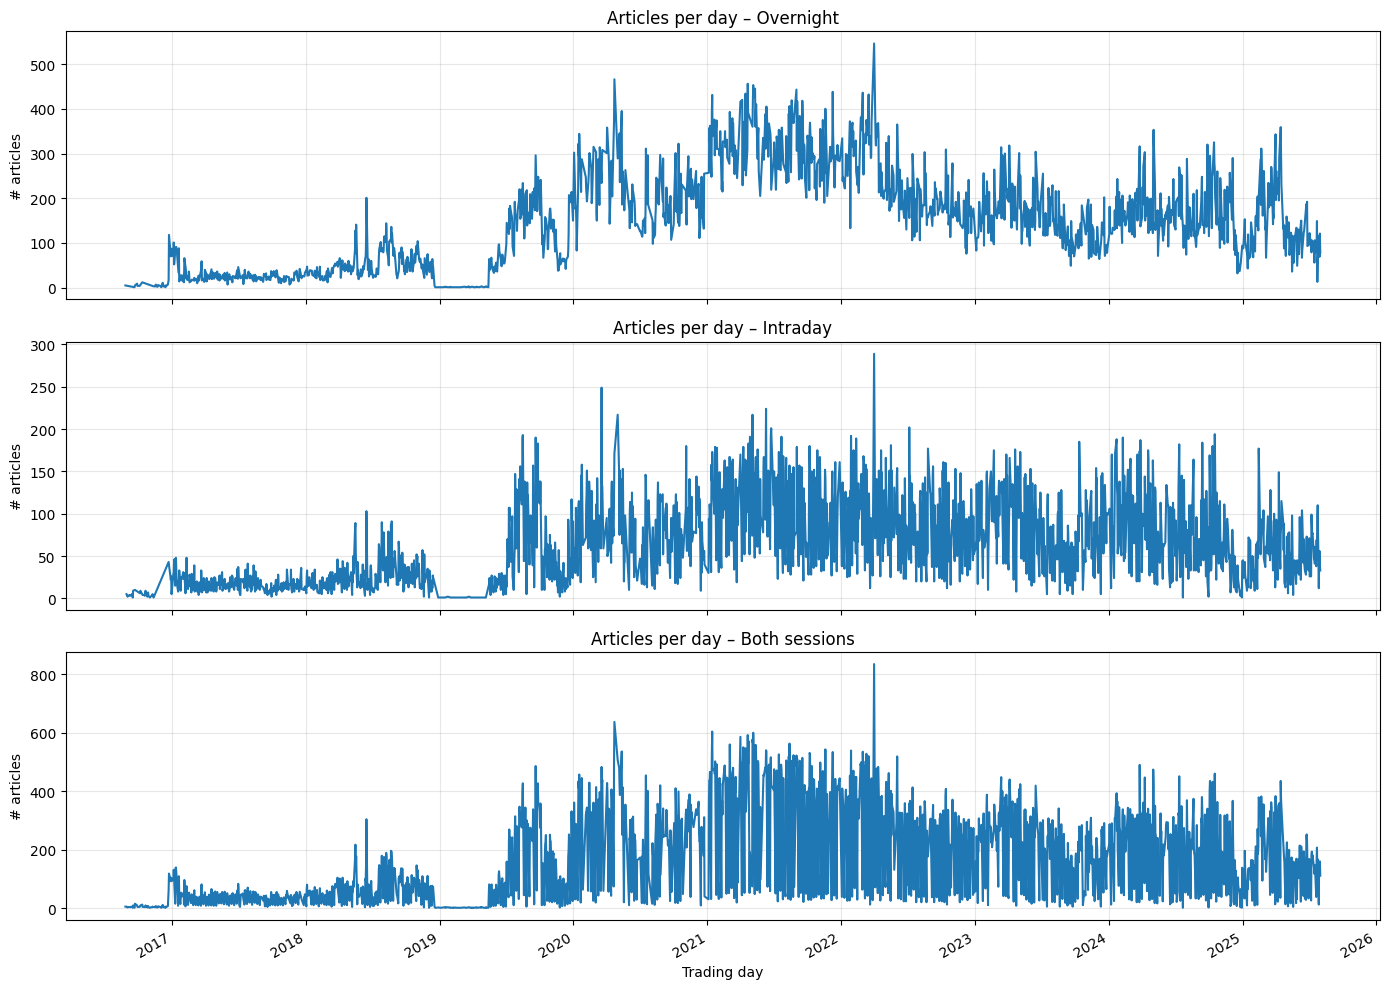

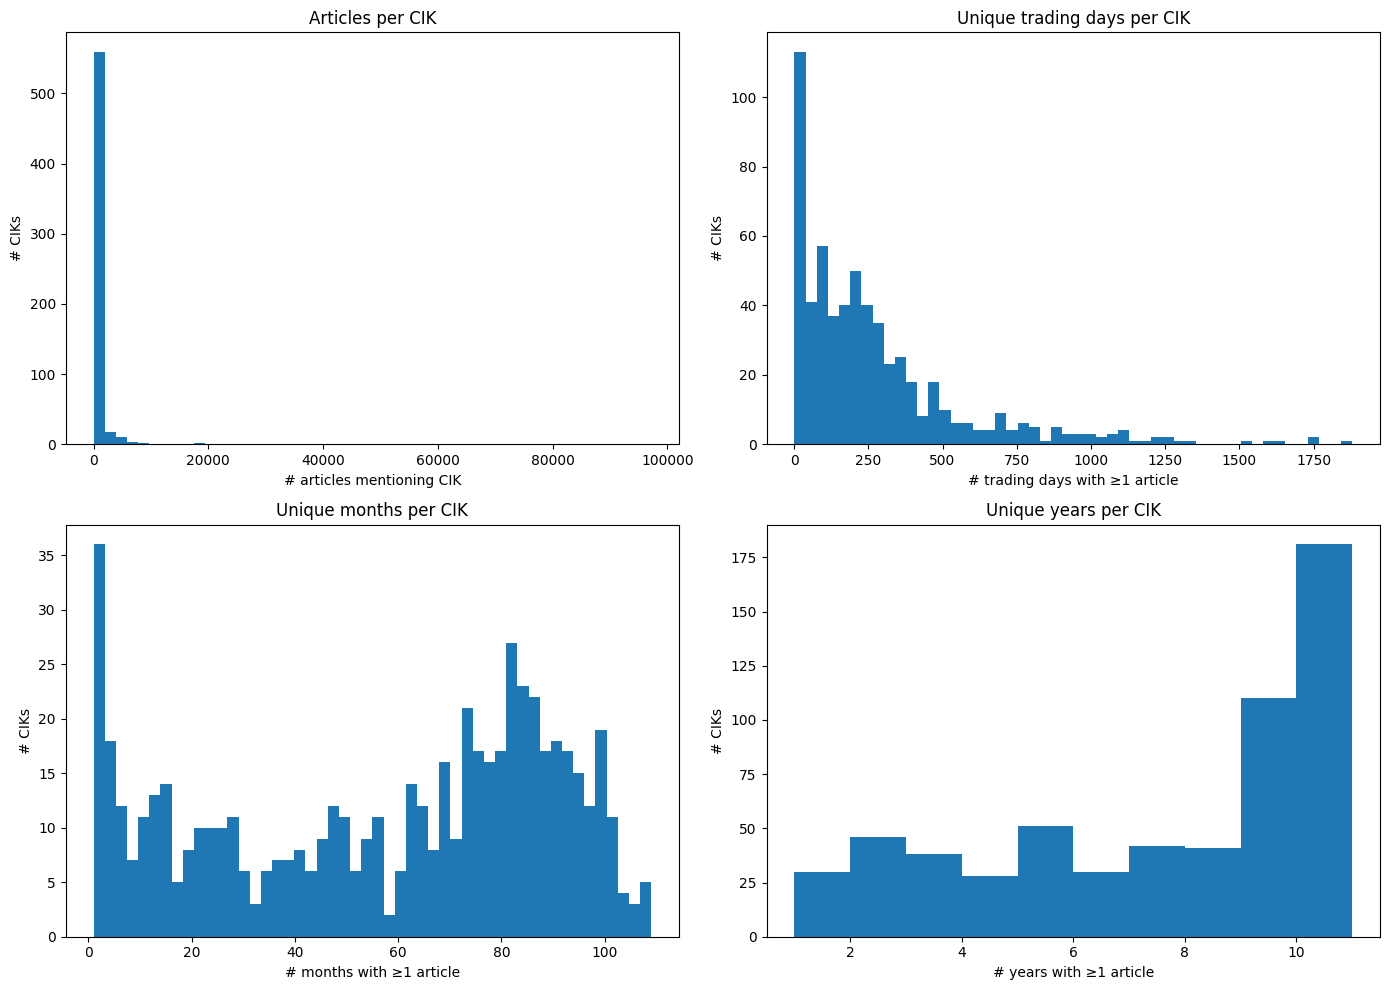

In [4]:
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_plotting import (
    plot_article_temporal_and_cik_coverage
)

plot_article_temporal_and_cik_coverage(filtered_sample_df)

## 1.3 Interim assessment of coverage and implications for LDA

### 1.3.1 Article-level coverage

The article-per-day plots indicate that, after the parser and post-parser
filters are applied, news coverage is reasonably dense over the full sample and
particularly stable from 2020 onward. Overnight and intraday sessions each
exhibit on the order of a few hundred retained articles per trading day, with:

- no extended runs of zero coverage;  
- only a small number of visible level shifts; and  
- broadly stable behavior in the 2020–2025 subperiod.

This pattern suggests that, at least in the later years, both sessions provide a
sufficiently rich stream of firm-specific news for topic modeling and
return-prediction work.

### 1.3.2 Firm-level coverage

The firm-level histograms reveal a more heterogeneous picture. A non-trivial
set of CIKs is only lightly covered, but:

- most firms have at least one filtered article over the sample;  
- most firms have at least one year with a retained article; and  
- a sizable subset of firms has dozens of months and hundreds of trading days
  with coverage.

The month and year distributions, in particular, indicate that many CIKs enjoy
sustained news flow throughout much of the 2016–2025 window, while a long tail
of sparsely covered firms would yield poorly estimated topic exposures.

### 1.3.3 Implications for LDA training and regressions

In light of these diagnostics, the initial LDA model will be trained on the
**full filtered corpus** from `2016-08-01` through `2025-08-01`. Early articles
are thus allowed to contribute information about the latent topic structure,
even in periods where coverage is relatively thin.

When constructing topic-exposure time series and running return regressions:

- attention will be restricted to dates and firms with **adequate news
  support**, rather than estimating exposures from a single article in an
  otherwise empty year; and  
- coverage diagnostics will be monitored for systematic instabilities,
  especially in the pre-2020 period.

If topic exposures are found to be unstable or unreliable before 2020, a second
iteration may be run in which the LDA training corpus is restricted to 2020
onward, and the resulting exposures compared against the baseline specification.

### 1.3.4 Motivation for validity-window-normalized coverage

The next subsection examines coverage **relative to each firm’s validity
window**. For every CIK, the following window-normalized coverage ratios will be
computed:

- the fraction of years in its validity window with at least one filtered
  article;  
- the fraction of months in its validity window with at least one filtered
  article; and  
- the fraction of trading days in its validity window with at least one
  filtered article.

These quantities provide a quantitative basis for defining minimum-coverage
thresholds and for selecting a tradable universe that is well supported by the
cleaned news corpus. At this stage, coverage is aggregated across sessions;
session-specific coverage can be introduced later if required by the modeling
design.

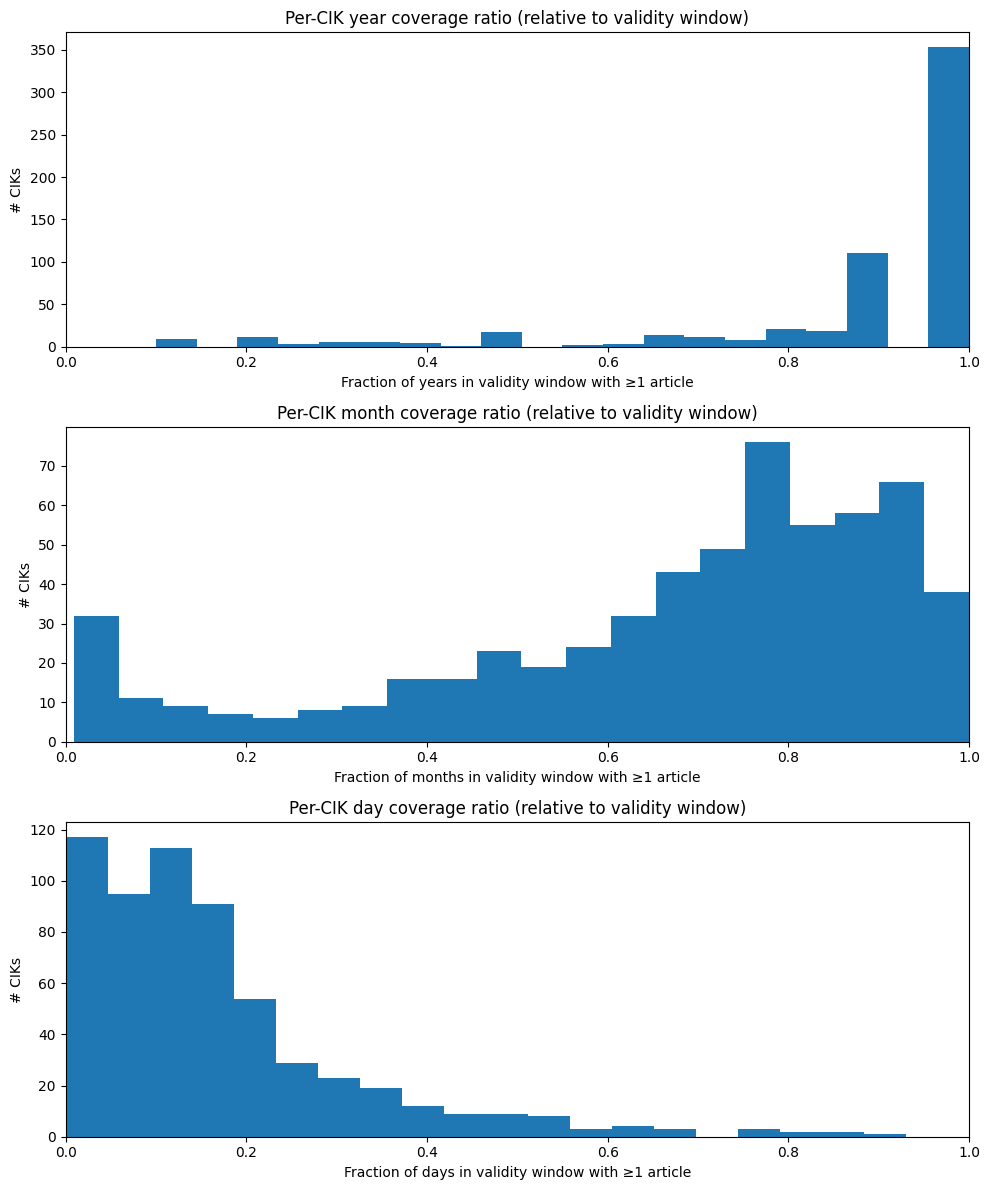

In [5]:
import sqlalchemy as sa
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_plotting import (
    compute_coverage, plot_window_normalized_coverage
)
article_sample_query: str = """
    SELECT cik, validity_window
    FROM ticker_cik_mapping
    WHERE cik = ANY(%(samples)s)
"""

engine: sa.Engine = connect_with_sqlalchemy()
cik_window_df: pd.DataFrame = pd.read_sql(
    article_sample_query,
    engine,
    params={"samples": list(filtered_sample_df['cik_list'].explode().unique())},
)
coverage_df: pd.DataFrame = compute_coverage(filtered_sample_df, cik_window_df)
plot_window_normalized_coverage(coverage_df)

### 1.4 Validity-window-normalized coverage and remaining universe

The validity-window-normalized coverage ratios translate the raw article counts into
fractions of each firm’s active life that are actually supported by filtered news. For
every CIK with at least one retained article, coverage is measured as the fraction of:

- years in its validity window that contain at least one filtered article;
- months in its validity window that contain at least one filtered article; and  
- trading days in its validity window that contain at least one filtered article.

Across the 597 CIKs with at least one article in their validity window and the
363,280 retained articles in the corpus, the resulting histograms indicate:

- **Year-level coverage.** More than 350 firms have a year-coverage ratio of 1.0,
  meaning that every year in their validity window contains at least one filtered
  article. Only a relatively small subset of firms has materially lower year-level
  coverage, so for a large portion of the universe topic exposures can be treated as
  being supported throughout the full episode.

- **Month-level coverage.** The month-coverage histogram is strongly right-skewed.
  A large majority of firms have at least half of their months covered by news
  (coverage ratio ≥ 0.5), and many firms sit near the upper tail with coverage
  ratios close to 1.0. This suggests that, conditional on being in the tradable
  universe, most firms exhibit sustained, month-to-month news flow.

- **Day-level coverage.** Day-coverage ratios are considerably sparser. For most
  firms, fewer than one fifth of the trading days in their validity window have a
  filtered article attached. Daily topic exposures will therefore be noisy unless
  some temporal smoothing or pooling is applied, especially for firms with thin
  coverage.

In line with the design choices outlined in Sections 1.2 and 1.3, the first LDA
iteration will include all 597 CIKs that have at least one filtered article within
their validity window, allowing every such firm to contribute to the estimation of
the latent topic structure. When constructing topic-exposure time series and
return-prediction regressions, firms and periods whose exposures appear unstable
or structurally under-supported can then be dropped or down-weighted based on
these coverage ratios.

The next section turns to the NLP processing required to convert the 363,280
filtered article bodies into an LDA-ready corpus: tokenization, normalization,
stop-word, vocabulary construction, and the creation of a
sparse document–term representation suitable for topic modeling.

# 2 Canonicalization and tokenization

The coverage diagnostics in Section 1 show that, after parser and post-parser filters, the
corpus consists of several hundred thousand filtered article bodies covering a broad cross-section
of firms. The next step is to convert these articles into an LDA-ready representation by applying
a simple, deterministic tokenization and canonicalization pipeline. This section describes what that pipeline does
and what the resulting token- and document-frequency distributions look like.

## 2.1 Canonicalization and tokenization pipeline

Starting from the filtered article set, we apply a batch preprocessing routine that operates on
the articles in chunks and maps each article body into a sequence of canonical tokens.

At a high level, the pipeline performs the following transformations:

- The article text is normalized: non-alphanumeric
  characters and obvious markup are stripped, punctuation is removed, and whitespace is
  collapsed. The normalized text is then split into word-like tokens, so that each token can
  be associated with a specific article identifier.

- Each token is classified as alphabetic, numeric, or alphanumeric. Purely alphabetic tokens
  are kept in word form; purely numeric tokens are grouped into a small number of magnitude
  buckets (ordinary numbers, million-scale numbers, and billion-scale numbers) so that the
  model retains information about scale without carrying around an unbounded vocabulary of
  raw numerals.

- Mixed alphanumeric strings (for example IDs, codes, or ticker-like patterns with digits)
  are simplified by removing their numeric component and retaining only the alphabetic
  part. This strips off noisy numeric suffixes while keeping the underlying word fragments
  that may carry meaning.

- The remaining alphabetic material is lower-cased and stemmed using an English stemmer.
  At the same time, a standard English stop-word list is stemmed in the same way, and any
  token whose stem lies in that list is removed. Very short stems and stems that still
  contain digits are also discarded. The result is a set of relatively clean, canonical
  token stems that are both compact and interpretable.

After these transformations, each article is represented as a collection of canonical tokens
linked to its article identifier. These `(article_id, stemmed_token)` pairs are written out as
partitioned Parquet files under a dedicated directory, providing a disk-backed, canonicalized
corpus that subsequent stages can use to construct the sparse document–term matrix for LDA.

> **Note — resource usage**
>
> Running `batch_canonicalize_and_tokenize_corpus` is intentionally CPU- and I/O-intensive.
> In earlier versions, materializing the fully canonicalized corpus as a single in-memory
> DataFrame consumed on the order of **22 GB** of RAM on a standard laptop.  
> To avoid this, the pipeline:
>
> - processes the filtered articles in chunks of size `CHUNK_SIZE`, and  
> - writes each chunk directly to disk as `tokenized_parquet/tokenized_corpus_chunk_<k>.parquet`
>   instead of returning one giant DataFrame.
>
> If the run is too heavy for your machine, you can:
>
> - **Lower `CHUNK_SIZE`** to reduce peak memory usage (at the cost of more, smaller Parquet files); and  
> - **Use `resume_index`** to restart a run from the next chunk after the last file you already
>   have. For example, if the last successfully written file is
>   `tokenized_corpus_chunk_5.parquet`, you can rerun the pipeline with `resume_index=5` to
>   continue from chunk 6 instead of starting over.
>
> These controls let you trade off runtime and disk usage against memory pressure so the
> canonicalization step can be executed safely on more modest hardware.

## 2.2 Token and document frequency diagnostics

Once the canonicalized corpus has been written to disk, we aggregate across all partitioned
files to construct two empirical distributions:

- a global term-frequency distribution, recording the total number of occurrences of each
  token in the entire corpus; and
- a document-frequency distribution, recording in how many distinct articles each token
  appears.

To make these distributions interpretable, the notebook converts them into
“counts-of-counts” histograms. For each integer frequency level $k$, we count how many
distinct tokens occur exactly $k$ times in the corpus, and how many tokens appear in
exactly $k$ articles. These histograms are plotted in two panels, with the y-axis on a
logarithmic scale. For readability, the x-axis in both panels is truncated at a frequency of
1,000; the underlying counters still track the full range of values, but the visualization
focuses on the part of the distribution where most tokens lie.

In these plots, a large mass of tokens lies very close to zero on the x-axis: most canonical
tokens appear only a handful of times in the entire corpus or in only a few articles. In
other words, a high proportion of the vocabulary is densely packed near the origin. As we
move to the right, the empirical density of tokens becomes progressively sparser. On the
log-scaled y-axis, the counts of tokens fall off roughly monotonically with frequency, and
only a small subset of words reaches the high end of the truncated range.

This heavy-tailed pattern is exactly what one would expect from a large,
canonicalized news corpus. It confirms that the preprocessing pipeline has produced a
vocabulary in which most items are rare or moderately frequent (and thus potentially
informative for firm- and context-specific topics), while a relatively small number of very
common tokens can be handled later through explicit vocabulary pruning or additional
stop-wording. These diagnostics provide a quantitative baseline for setting minimum and
maximum frequency thresholds before constructing the final sparse document–term
representation for LDA training.

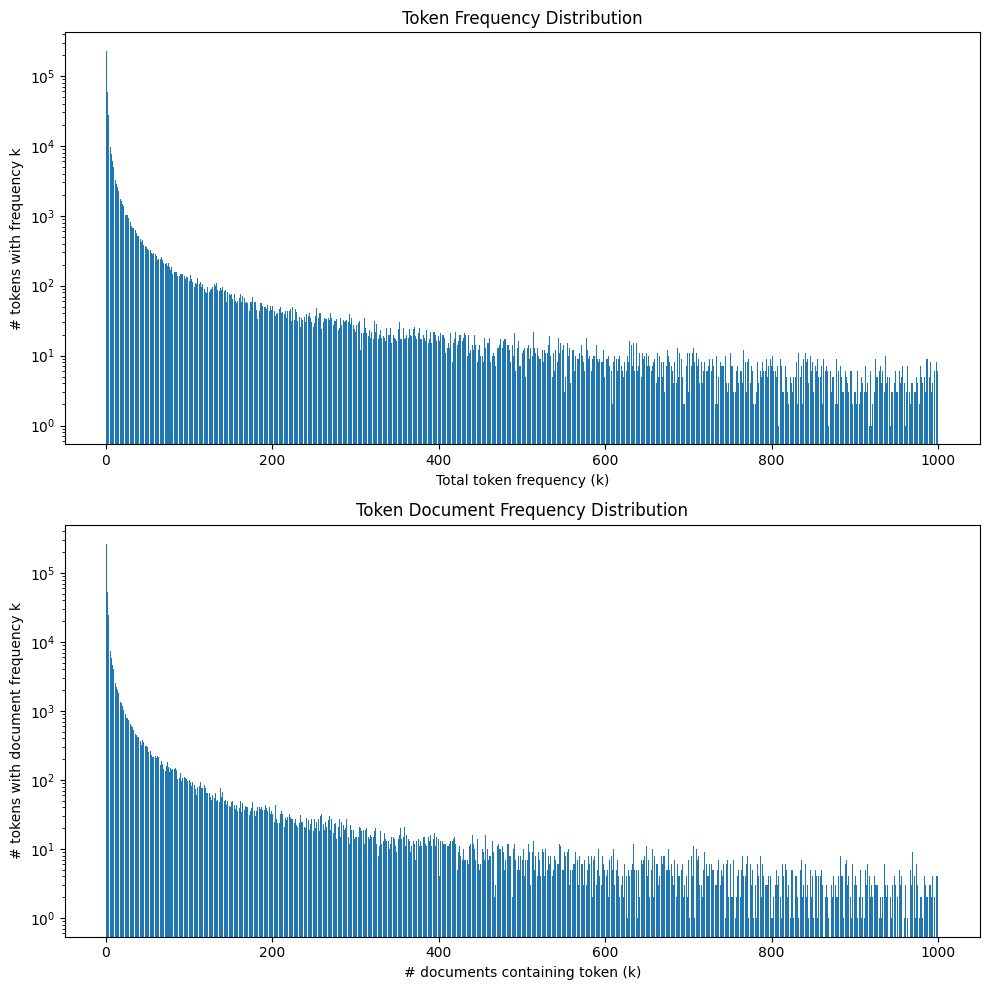

In [6]:
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_utils import (
    FrequencyCounters,
    batch_canonicalize_and_tokenize_corpus,
    extract_token_distributions
)
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_plotting import (
    plot_token_and_doc_frequency
)

# For logging to appear change the log level to DEBUG.
# This is a No-OP unless real_run=True.
batch_canonicalize_and_tokenize_corpus(filtered_sample_df, logger)
frequency_counters: FrequencyCounters = extract_token_distributions()
plot_token_and_doc_frequency(frequency_counters.token_frequency_counter, frequency_counters.token_document_counter)

## 2.3 Vocabulary pruning and rare-term filter

The canonicalized corpus provides, for each token, both a global term count
(total number of occurrences across all articles) and a document frequency
(number of distinct articles in which the token appears). Before constructing
the final LDA inputs, we apply a simple rare-term filter and inspect the
resulting vocabularies.

The rare-term filter is defined at the document level. Tokens that appear in
fewer than 25 articles are dropped from the active vocabulary. For a corpus of
this size, this threshold removes extremely idiosyncratic words that are
unlikely to support stable topics, while retaining tokens that recur with at
least minimal regularity across the news stream.

Concretely:

- We compute the size of the vocabulary **before** pruning (number of distinct
  canonical tokens in the corpus).
- We apply the document-frequency threshold (document_frequency ≥ 25) and record
  the vocabulary size **after** pruning.
- We measure how much token mass is removed by this step: both in terms of the
  fraction of vocabulary types dropped and the fraction of total token
  occurrences they represent.

As a diagnostic sanity check, we also examine the most frequent tokens in the
corpus (e.g., the top 10–20 tokens by global term count and by document
frequency). The goal is to verify that:

- the highest-frequency items look like genuine news vocabulary and not
  artifacts of the parsing pipeline; and
- any residual boilerplate terms that escaped earlier cleaning can be flagged
  for potential exclusion (for example, by marking them inactive in the
  vocabulary table).

The main effect of this stage is to define an **active vocabulary**: the set of
tokens that pass the document-frequency filter and are candidates for inclusion
in LDA training.

## 2.4 From canonicalized corpus to LDA tables

Once the active vocabulary has been identified, the canonicalized corpus is
mapped into three SQL tables that together define the LDA input:

1. a per-article document view;
2. a versioned vocabulary with frequency statistics; and
3. a sparse document–term matrix linking the two.

These tables are implemented as:

```sql
-- Cleaned per-article documents
CREATE TABLE lda_documents (
    article_id          TEXT,
    corpus_version      SMALLINT NOT NULL,
    included_in_training BOOLEAN NOT NULL DEFAULT TRUE,
    token_count         INTEGER NOT NULL,
    unique_token_count  INTEGER NOT NULL,
    created_at          TIMESTAMPTZ NOT NULL DEFAULT NOW(),
    PRIMARY KEY (article_id, corpus_version)
);

-- Global vocabulary with per-token statistics
CREATE TABLE lda_vocabulary (
    term_id             SERIAL PRIMARY KEY,
    token               TEXT NOT NULL,
    corpus_version      SMALLINT NOT NULL,
    global_term_count   BIGINT NOT NULL,
    document_frequency  INTEGER NOT NULL,
    is_active           BOOLEAN NOT NULL DEFAULT TRUE,
    created_at          TIMESTAMPTZ NOT NULL DEFAULT NOW(),
    UNIQUE (token, corpus_version)
);

-- Sparse document–term matrix
CREATE TABLE lda_document_terms (
    article_id      TEXT,
    corpus_version  SMALLINT,
    term_id         INTEGER,
    term_count      INTEGER NOT NULL,
    PRIMARY KEY (article_id, corpus_version, term_id)
);
````

The loading process proceeds in three conceptual steps.

### 2.4.1 Building the per-article documents

For each article in the canonicalized corpus:

* All canonical tokens that belong to the **active vocabulary** are collected.
* Two simple counts are computed:

  * `token_count`: total number of tokens in the article, and
  * `unique_token_count`: number of distinct tokens in the article.

These values, together with the `article_id` and chosen $`corpus\_version` = 1$, are
inserted into `lda_documents`. At this point, each row in `lda_documents`
represents the cleaned bag-of-words view of a single article under a specific
corpus construction.

### 2.4.2 Constructing the vocabulary with frequencies

From our two previous counters, we already have:

* For each token in the **active vocabulary**:

  * `global_term_count`: the total number of times the token appears across all
    articles in this corpus version; and
  * `document_frequency`: the number of distinct articles containing at least
    one occurrence of the token.

These aggregates, with the cleaned and stemmed token symbol, are loaded
into `lda_vocabulary` for the chosen $`corpus\_version` = 1$. The `is_active` flag
is set to `TRUE` (By default);

### 2.4.3 Populating the document–term matrix

Finally, we construct the sparse document–term matrix:

* For each article and each token in the active vocabulary that appears in that
  article, we compute the number of occurrences of that token.
* Each such pair is mapped to a vocabulary identifier via `term_id` and `article_id`.
* A row is inserted into `lda_document_terms` with
  `(article_id, corpus_version, term_id, term_count)`.

This table provides the integer counts consumed by LDA, while `lda_documents`
and `lda_vocabulary` supply the corresponding textual and frequency metadata.
Together, the three tables define a versioned, fully auditable corpus representation:
changing the cleaning rules or vocabulary thresholds simply results in a new `corpus_version`,
allowing multiple LDA runs to coexist without losing the provenance of earlier constructions.

In [7]:
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.corpus_exploration_and_cleaning_utils import (
    delete_parquet_chunks, summarize_and_filter_vocabulary
)

frequency_counters = summarize_and_filter_vocabulary(frequency_counters)

Top 20 tokens by global term count
------------------------------------------------------------
rank  token                  term_count     doc_freq
   1  __NUM__                  32279283       361553
   2  share                     4348482       314374
   3  stock                     3898699       300498
   4  compani                   3370516       332437
   5  quarter                   2560099       260541
   6  rate                      2530495       271780
   7  price                     1756400       277663
   8  report                    1658094       298857
   9  inc                       1341065       300960
  10  th                        1336017       215816
  11  market                    1279727       302194
  12  research                  1188209       241271
  13  averag                    1126558       266006
  14  hold                      1116109       259685
  15  analyst                   1104046       261676
  16  year                      1096635       282367
  1

In [ ]:
from notebooks_utils.data_notebooks_utils.corpus_exploration_and_cleaning_utils.load_tables import load_corpus_tables

# This is a No-OP if real_run is not set to TRUE.
# For logging to appear change the log level to DEBUG.
# Takes approximatly 50 minutes.
load_corpus_tables(frequency_counters, logger)
delete_parquet_chunks() # This is a No-OP if real_run is not set to TRUE.